In [23]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
transactions = pd.read_csv('Transactions.csv')
customers = pd.read_csv('Customers.csv')

Preprocessing

In [25]:
transactions_agg = transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
).reset_index()

In [26]:
transactions_agg

,CustomerID,total_spent,total_quantity,avg_transaction_value
0,C0001,3354.52,12,670.904000
1,C0002,1862.74,10,465.685000
2,C0003,2725.38,14,681.345000
3,C0004,5354.88,23,669.360000
4,C0005,2034.24,7,678.080000
...,...,...,...,...
194,C0196,4982.88,12,1245.720000
195,C0197,1928.65,9,642.883333
196,C0198,931.83,3,465.915000
197,C0199,1979.28,9,494.820000


Merge customer data with transaction data

In [27]:
customer_data = pd.merge(customers, transactions_agg, on='CustomerID', how='inner')

In [28]:
customer_data

,CustomerID,CustomerName,Region,SignupDate,total_spent,total_quantity,avg_transaction_value
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,12,670.904000
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,10,465.685000
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,14,681.345000
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,23,669.360000
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,7,678.080000
...,...,...,...,...,...,...,...
194,C0196,Laura Watts,Europe,2022-06-07,4982.88,12,1245.720000
195,C0197,Christina Harvey,Europe,2023-03-21,1928.65,9,642.883333
196,C0198,Rebecca Ray,Europe,2022-02-27,931.83,3,465.915000
197,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,9,494.820000


One-hot encoding for Region

In [29]:
encoder = OneHotEncoder()
encoded_regions = encoder.fit_transform(customer_data[['Region']]).toarray()
encoded_regions_df = pd.DataFrame(
    encoded_regions, columns=[f"region_{cat}" for cat in encoder.categories_[0]]
)


In [30]:
encoded_regions_df

,region_Asia,region_Europe,region_North America,region_South America
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
194,0.0,1.0,0.0,0.0
195,0.0,1.0,0.0,0.0
196,0.0,1.0,0.0,0.0
197,0.0,1.0,0.0,0.0


Combine all features

In [31]:
customer_data = pd.concat([customer_data, encoded_regions_df], axis=1)

In [32]:
customer_data.drop(columns=['Region', 'CustomerID','CustomerName','SignupDate'], inplace=True)

In [33]:
customer_data.head()

,total_spent,total_quantity,avg_transaction_value,region_Asia,region_Europe,region_North America,region_South America
0,3354.52,12,670.904,0.0,0.0,0.0,1.0
1,1862.74,10,465.685,1.0,0.0,0.0,0.0
2,2725.38,14,681.345,0.0,0.0,0.0,1.0
3,5354.88,23,669.360,0.0,0.0,0.0,1.0
4,2034.24,7,678.080,1.0,0.0,0.0,0.0


Scale numerical features

In [34]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

Clustering and Evaluation

In [35]:
dbi_scores = []
inertia_scores = []
cluster_range = range(2, 11)
cluster_labels = {}

In [36]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    dbi = davies_bouldin_score(scaled_data, labels)
    dbi_scores.append(dbi)
    inertia_scores.append(kmeans.inertia_)
    cluster_labels[k] = labels

Select optimal cluster count (lowest DBI)

In [37]:
optimal_clusters = cluster_range[dbi_scores.index(min(dbi_scores))]
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_labels = final_kmeans.fit_predict(scaled_data)

Add cluster labels to original data

In [38]:
customer_data['Cluster'] = final_labels

Visualization: PCA for dimensionality reduction

In [39]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
customer_data['PCA1'] = pca_result[:, 0]
customer_data['PCA2'] = pca_result[:, 1]

Scatter plot of clusters

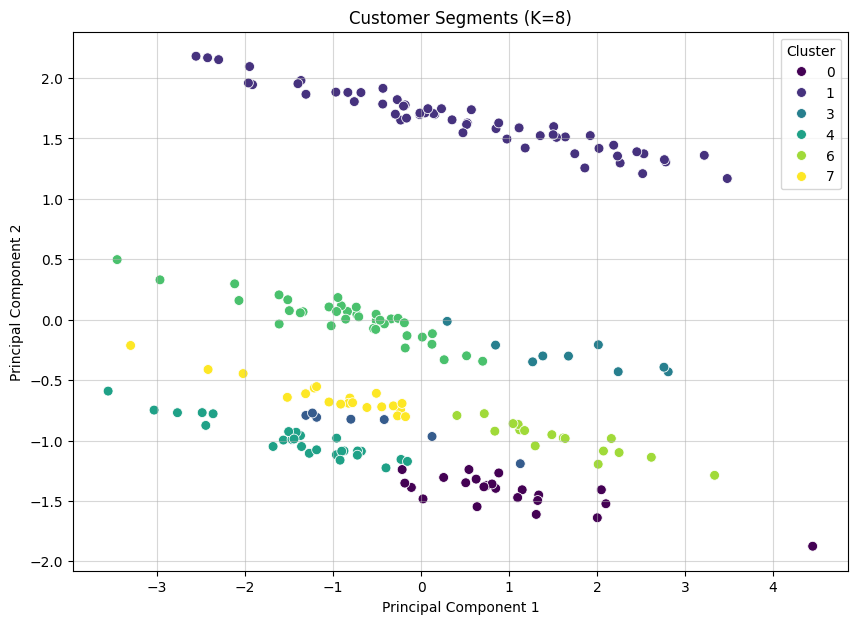

In [40]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=customer_data, s=50
)
plt.title(f"Customer Segments (K={optimal_clusters})")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(alpha=0.5)
plt.show()

Evaluation Metrics: Plot DBI and Inertia

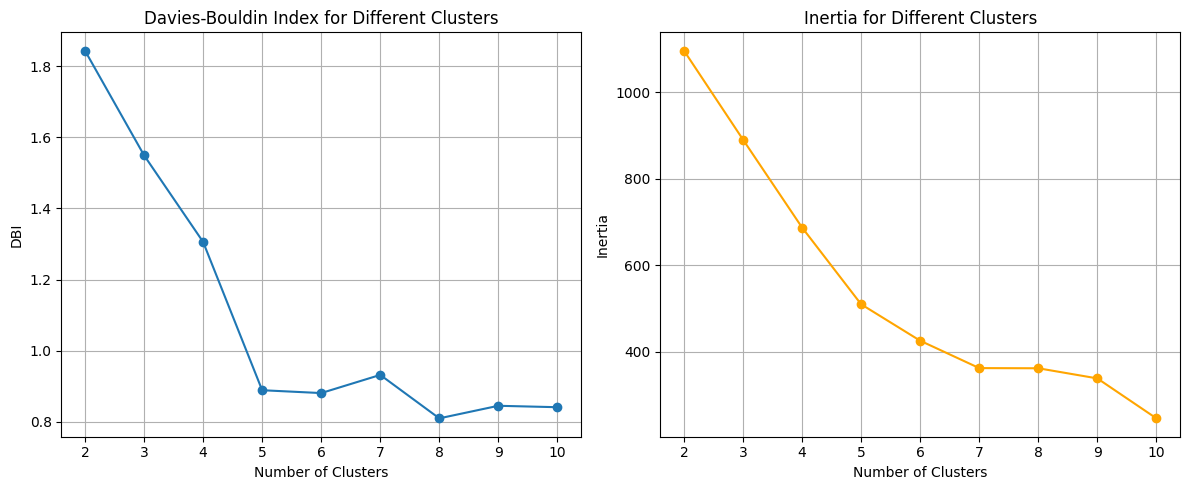

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, dbi_scores, marker='o', label='DBI')
plt.title('Davies-Bouldin Index for Different Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DBI')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(cluster_range, inertia_scores, marker='o', label='Inertia', color='orange')
plt.title('Inertia for Different Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()

plt.tight_layout()
plt.show()

In [42]:
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Minimum DBI: {min(dbi_scores)}")


Optimal Number of Clusters: 8
Minimum DBI: 0.8098283807089584
